# Testing for Generating Randomized Geological Histories

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

from structgeo.model import geo
import structgeo.plot as geovis
from structgeo.model import history as geohistory
import structgeo.probability as rv

pv.set_jupyter_backend('static')

In [58]:
# Set random seed for reproducibility
# random_seed = 1234
# np.random.seed(random_seed)

In [59]:
# Start with some model specifications
# Randomize the bounds size between 10 and 100
resolution = 128
max_x = float(np.random.randint(10, 100))
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

Model created with bounds (-46.0, 46.0) and resolution 128


In [60]:
# Make an origin generator for generating feature origins
def get_origin_generator(bounds):
    def origin_generator():
        return rv.random_point_in_ellipsoid(bounds)
    return origin_generator

origin_generator = get_origin_generator(bounds)

for i in range(5):
    origin = origin_generator()
    print(f"Origin {i}: {origin}")

Origin 0: (11.368570324922201, -13.397555449412584, 28.273185413147413)
Origin 1: (0.4957016890512704, 8.003393360841564, 3.977938621940858)
Origin 2: (0.23367949460512497, 5.351282637048507, -5.500922459595646)
Origin 3: (24.446478910812715, -20.602079444602847, -22.5413555649069)
Origin 4: (-2.7091843870850374, -8.507981631556632, 3.37864943855696)


In [61]:
# random bedrock in lower 1/4 of model
base = min_x + model_size / 4 + np.random.normal(0, model_size / 10)
value = 0
bedrock = geo.Bedrock(base,value)
print(f"Bedrock defined at {base} with value {value}")

Bedrock defined at -17.2397356161073 with value 0


In [62]:
# Random sedimentary layer filled to around 1/2 of the model
height = base + model_size / 3 + np.random.normal(0, model_size / 10)
height = max(height, base + model_size/10)
avg_thickness = (height-base)/10
print(f"Average thickness of sedimentary layer is {avg_thickness}")
sediment = geo.Sedimentation(height=height, value_list = [2,3,4], thickness_callable = lambda: np.random.lognormal(np.log(avg_thickness),1))
print(f"Sedimentary layer defined at {height} with values {sediment.value_list}")

Average thickness of sedimentary layer is 2.2918717572304486
Sedimentary layer defined at 5.678981956197187 with values [2, 3, 4]


In [63]:
# Add random dike
strike = rv.random_angle_degrees()
dip = np.random.uniform(60,120)
width = np.random.uniform(2,model_size/5)
origin = origin_generator()
value = 5

dike = geo.Dike(strike=strike, dip=dip, width=width, origin=origin, value=value)

print(f"Dike defined with strike {strike}, dip {dip}, width {width}, origin {origin} and value {value}")

Dike defined with strike 350.3334178851842, dip 91.09726910001014, width 13.03391026891907, origin (-7.473253671142364, -9.62721601380295, -21.748747299172543) and value 5


In [64]:
# Add random tilt
strike = rv.random_angle_degrees()
dip = np.random.uniform(0,35)
origin = origin_generator()
tilt = geo.Tilt(strike=strike, dip=dip, origin=origin)

In [65]:
# add random fold
strike = rv.random_angle_degrees()
dip = np.random.uniform(60,120)
rake = rv.random_angle_degrees()
origin = origin_generator()
amplitude = np.random.uniform(0, model_size/8)
period = np.random.uniform(model_size/2, model_size*4)
periodic_func = rv.fourier_series_wave(num_harmonics=10)
fold = geo.Fold(strike=strike, dip=dip, rake=rake, origin=origin, amplitude=amplitude, period=period, periodic_func=periodic_func)


In [66]:
# Add random fault
strike = rv.random_angle_degrees()
dip = np.random.uniform(60,100)
rake = np.random.uniform(0,180)
amplitude = np.random.uniform(2, model_size/20)
origin = origin_generator()
fault = geo.Fault(strike=strike, dip=dip, rake=rake, origin=origin, amplitude=amplitude)


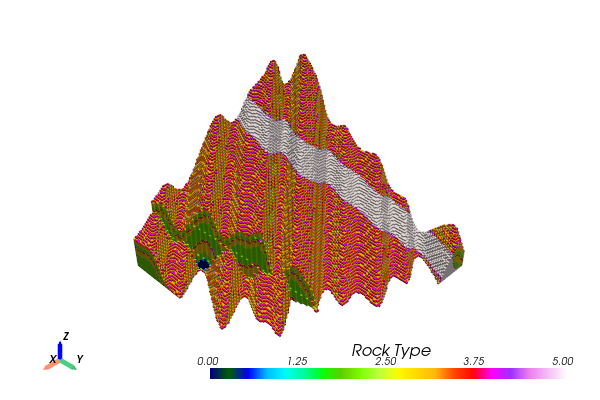

In [67]:
model.clear_history()
model.add_history([bedrock, sediment, dike, tilt, fold, fault])
model.compute_model()
p = geovis.volview(model)
p.show(window_size=[600,400])